In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import tensor
from torch import sum as tsum
import torch
from tqdm import tqdm

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
# run simulation in gpu
from lbm import device
# x and y tunnel dimensions and airfoil coordinates
from obs import nx,ny,naca0012_x,naca0012_y

import lbm
import obs
import algs

In [ ]:
rng = np.random.default_rng()

# bump parameters
cx_t = rng.uniform(low=0.6, high=0.85)
r_t = rng.uniform(low=0.02, high=0.04)
off_t = rng.uniform(high=0.5)

---
---
#### Airfoil mask and external boundary

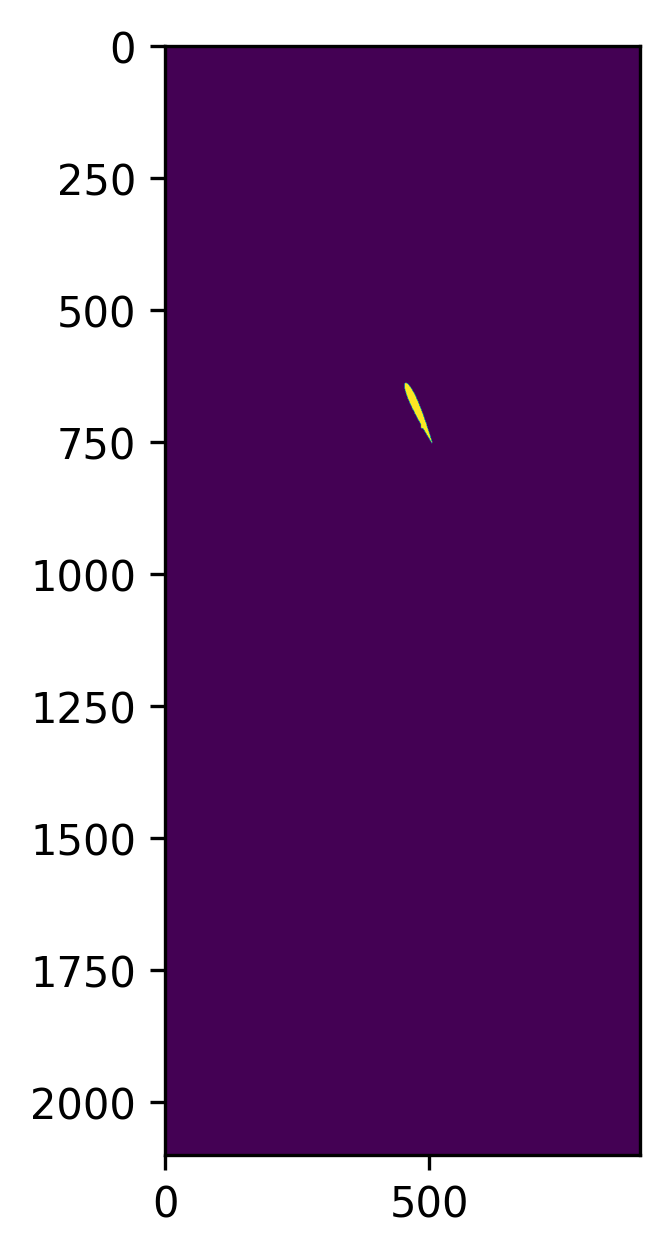

In [4]:
plt.imshow(obs.get_profile_mask([cx_t,r_t,off_t]))

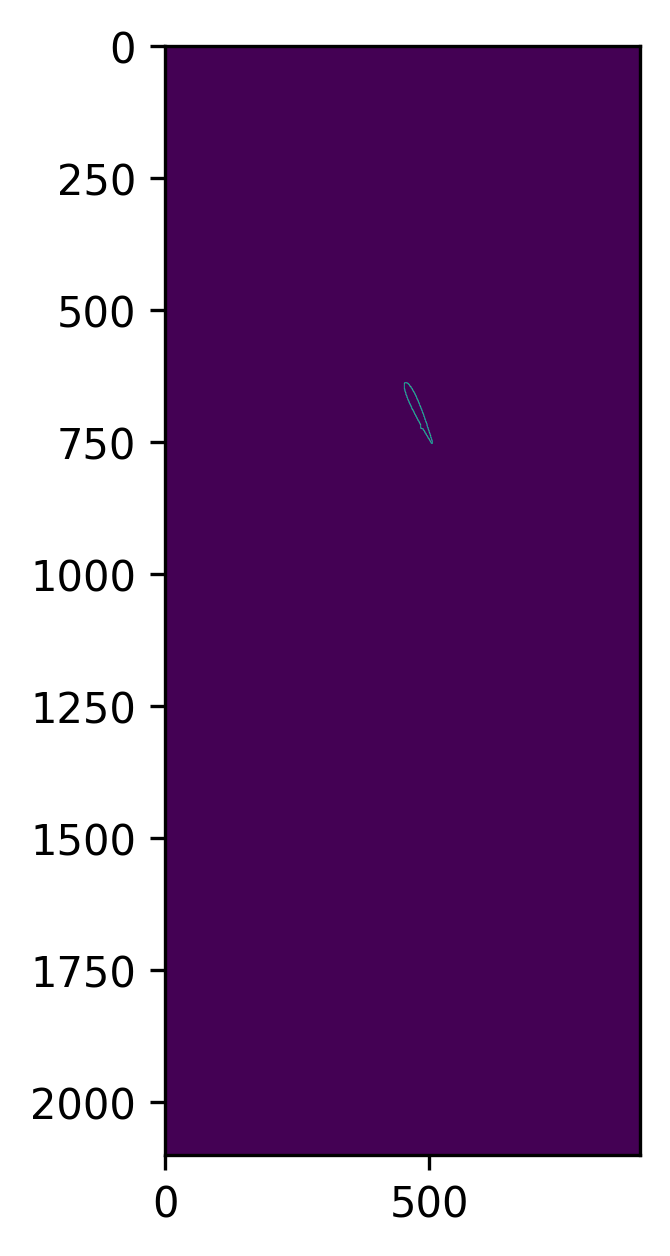

In [5]:
obstacle_mask = obs.get_profile_mask([cx_t,r_t,off_t])
extbdry_mask = obs.get_extbdry_mask(obstacle_mask)
plt.imshow(extbdry_mask)

In [6]:
# measure chord length C, which is the maximum number shown (125)
foil_m = obs.obs_mask(0, [naca0012_x,naca0012_y])
for j in range(440,470):
    nod = np.sum(foil_m[:,j])
    print(j, nod)

440 0
441 0
442 0
443 0
444 0
445 0
446 0
447 37
448 60
449 77
450 89
451 102
452 111
453 120
454 125
455 120
456 111
457 101
458 89
459 76
460 60
461 37
462 0
463 0
464 0
465 0
466 0
467 0
468 0
469 0


---
---
#### Velocity, pressure and vorticity fields

In [8]:
obstacle_mask_nb = obs.obs_mask(np.pi*(16/180), [naca0012_x,naca0012_y])
extbdry_mask_nb = obs.get_extbdry_mask(obstacle_mask_nb)
obstacle_nb = tensor(obstacle_mask_nb).to(device)
extbdry_nb = obs.get_links(obstacle_mask_nb, extbdry_mask_nb)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [1:09:42<00:00, 11.95it/s]


time to execute =  4182.4233293533325


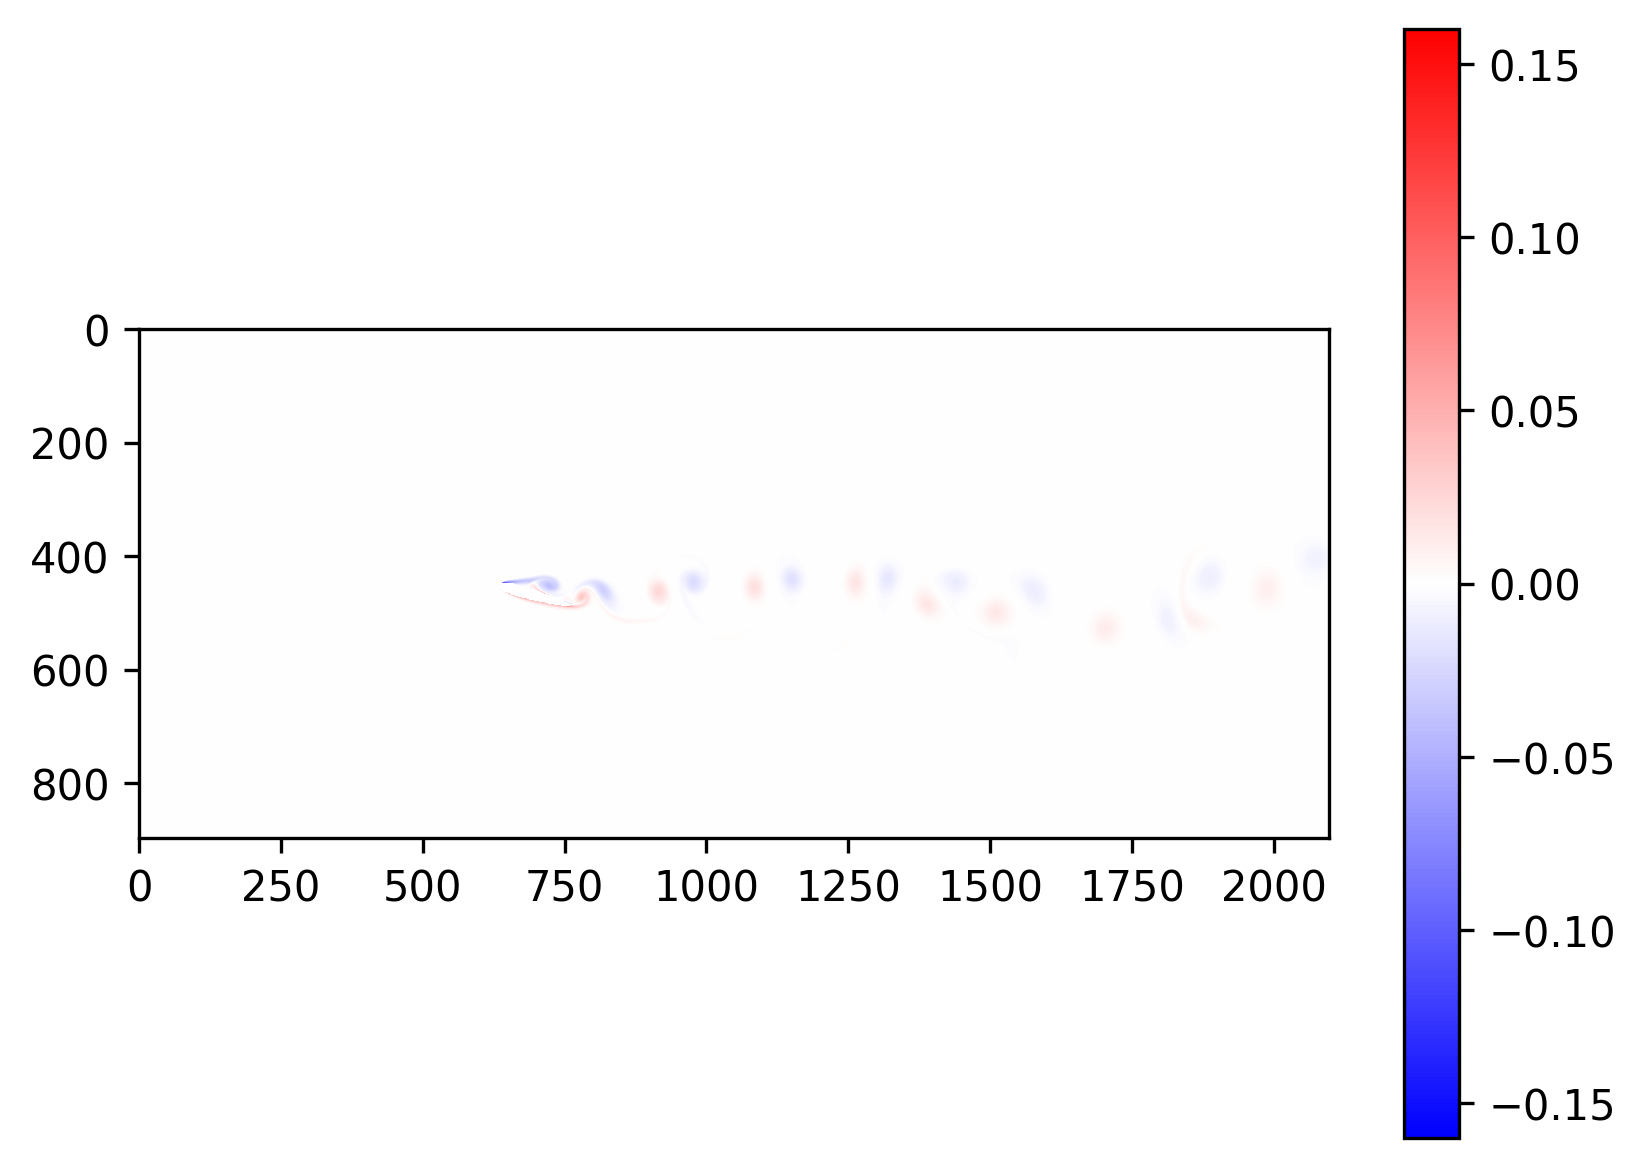

In [29]:
Cl_nb, Cd_nb = lbm.lbm_sim(extbdry_nb, obstacle_nb, nx, ny, 1000.0, uLB=0.2/np.sqrt(3), C=125, img=True, t_img=25, coefs=False, tF_start=45000)

---

In [31]:
obstacle_mask = obs.get_profile_mask(np.asarray(profiles.iloc[0]), rot_ang=np.pi*(16/180))
extbdry_mask = obs.get_extbdry_mask(obstacle_mask)
obstacle = tensor(obstacle_mask).to(device)
extbdry = obs.get_links(obstacle_mask, extbdry_mask)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [1:10:01<00:00, 11.90it/s]


time to execute =  4201.125213384628


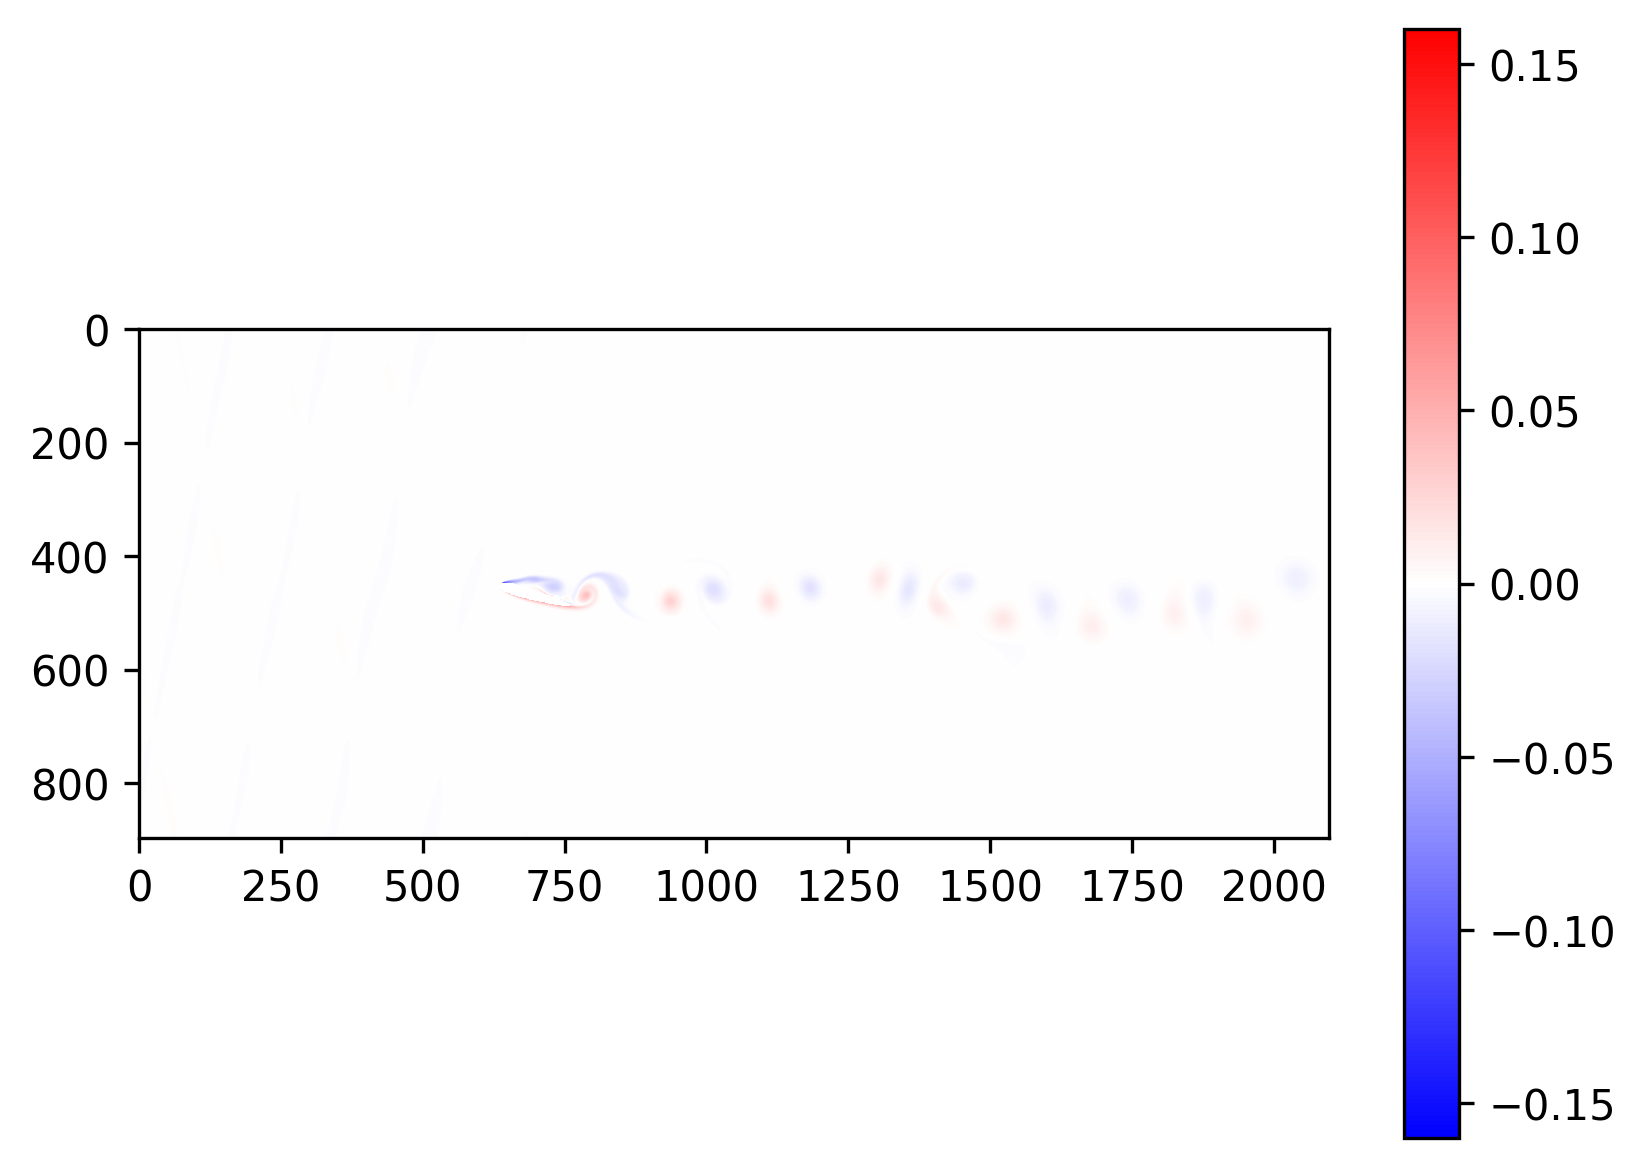

In [32]:
Cl, Cd = lbm.lbm_sim(extbdry, obstacle, nx, ny, Re=1000.0, uLB=0.2/np.sqrt(3), C=125, img=True, t_img=25, coefs=False, tF_start=45000)

In [24]:
tsum(Cl.cpu()).item() / 50

0.6657736206054687

In [27]:
(tsum(Cl.cpu()).item() / 50) / (tsum(Cd.cpu()).item() / 50)

2.0922132653385384

In [28]:
(tsum(Cl_nb.cpu()).item() / 50) / (tsum(Cd_nb.cpu()).item() / 50)

2.0369399543369338

---
---
#### Fitness function and airfoil optimization

In [7]:
# Takes entire population as argument. nx, ny, are global variables
def fit_lbm(pop, aoa=np.pi*(16/180), Re=1000.0, uLB=0.2/np.sqrt(3), tF_start=10000, tF_out=100, F_num=50):
    n = len(pop)
    fit = np.zeros(n)
    
    for i in range(n):
        p = pop[i]    # p is [cx, r, y_off]
        
        # Generate boolean masks and identify
        # lattice links cutting into the obstacle
        obstacle_mask = obs.get_profile_mask(p, rot_ang=aoa)
        extbdry_mask = obs.get_extbdry_mask(obstacle_mask)
        obstacle = tensor(obstacle_mask).to(device)
        extbdry = obs.get_links(obstacle_mask, extbdry_mask)

        # run simulation to get Cl, Cd arrays
        Cl, Cd = lbm.lbm_sim(extbdry, obstacle, nx, ny, Re=Re, uLB=uLB, tF_start=tF_start, tF_out=tF_out, F_num=F_num)
        Cl_avg = tsum(Cl.cpu()).item() / F_num    # average lift coeff
        Cd_avg = tsum(Cd.cpu()).item() / F_num    # average drag coeff
        fit[i] = Cl_avg / Cd_avg

    return fit

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.09it/s]


time to execute =  267.4244759082794


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.45it/s]


time to execute =  265.72320222854614


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.56it/s]


time to execute =  265.18764781951904


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.45it/s]


time to execute =  261.10065841674805


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.84it/s]


time to execute =  259.3160619735718


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.51it/s]


time to execute =  256.3699994087219
Running fit eval 1


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.45it/s]


time to execute =  256.6299982070923


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:15<00:00, 58.63it/s]


time to execute =  255.8299994468689


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.52it/s]


time to execute =  256.3199999332428


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.33it/s]


time to execute =  257.16000175476074


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.25it/s]


time to execute =  257.501704454422


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:15<00:00, 58.63it/s]


time to execute =  255.82999968528748
Running fit eval 2


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.08it/s]


time to execute =  258.2699990272522


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.33it/s]


time to execute =  257.1599988937378


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.25it/s]


time to execute =  257.510000705719


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.55it/s]


time to execute =  256.1799998283386


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.46it/s]


time to execute =  256.5999975204468


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.37it/s]


time to execute =  261.45999789237976
Running fit eval 3


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.51it/s]


time to execute =  260.82000207901


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.71it/s]


time to execute =  259.90999603271484


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.58it/s]


time to execute =  256.0399897098541


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.46it/s]


time to execute =  256.58000016212463


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.18it/s]


time to execute =  257.8250114917755


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.11it/s]


time to execute =  258.130001783371
Running fit eval 4


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.35it/s]


time to execute =  257.0514123439789


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.32it/s]


time to execute =  257.17999935150146


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.39it/s]


time to execute =  256.8999924659729


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.46it/s]


time to execute =  256.5799992084503


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.95it/s]


time to execute =  263.3866138458252


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.85it/s]


time to execute =  263.8299984931946
Running fit eval 5


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.40it/s]


time to execute =  261.3399999141693


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.82it/s]


time to execute =  259.42999815940857


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.54it/s]


time to execute =  256.2300007343292


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.11it/s]


time to execute =  258.1399862766266


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.30it/s]


time to execute =  257.30999994277954


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.46it/s]


time to execute =  256.5900001525879
Running fit eval 6


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.99it/s]


time to execute =  258.6681694984436


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 57.02it/s]


time to execute =  263.0799970626831


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.07it/s]


time to execute =  262.8331472873688


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.28it/s]


time to execute =  261.8699998855591


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.12it/s]


time to execute =  258.0700001716614


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.22it/s]


time to execute =  257.64999556541443
Running fit eval 7


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.69it/s]


time to execute =  260.03000140190125


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.85it/s]


time to execute =  259.2999978065491


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.13it/s]


time to execute =  258.03999972343445


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.14it/s]


time to execute =  257.97999906539917


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.14it/s]


time to execute =  262.5100018978119


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.95it/s]


time to execute =  263.3699975013733
Running fit eval 8


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.16it/s]


time to execute =  262.4099979400635


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.96it/s]


time to execute =  258.7799973487854


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.68it/s]


time to execute =  260.0599994659424


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.85it/s]


time to execute =  259.2816984653473


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.55it/s]


time to execute =  260.6299982070923


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.92it/s]


time to execute =  258.9700014591217
Running fit eval 9


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.91it/s]


time to execute =  259.0366909503937


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.77it/s]


time to execute =  264.2299962043762


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.84it/s]


time to execute =  263.91000151634216


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.99it/s]


time to execute =  263.2000002861023


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.97it/s]


time to execute =  258.7500011920929


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.55it/s]


time to execute =  260.6499991416931
Running fit eval 10


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.64it/s]


time to execute =  260.25999999046326


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.76it/s]


time to execute =  259.70000195503235


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.02it/s]


time to execute =  258.5299983024597


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.17it/s]


time to execute =  257.8699994087219


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.74it/s]


time to execute =  264.3600010871887


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.58it/s]


time to execute =  265.13139295578003
Running fit eval 11


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.88it/s]


time to execute =  263.7200002670288


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.94it/s]


time to execute =  258.91999864578247


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.73it/s]


time to execute =  259.849999666214


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.15it/s]


time to execute =  257.9500000476837


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.35it/s]


time to execute =  261.5399978160858


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.44it/s]


time to execute =  261.13811898231506
Running fit eval 12


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.49it/s]


time to execute =  265.53000116348267


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.58it/s]


time to execute =  265.1099965572357


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.16it/s]


time to execute =  262.4399902820587


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.81it/s]


time to execute =  259.4899995326996


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.46it/s]


time to execute =  265.67901515960693


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.42it/s]


time to execute =  265.8799936771393
Running fit eval 13


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.88it/s]


time to execute =  263.69999957084656


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.98it/s]


time to execute =  258.70172810554504


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.75it/s]


time to execute =  259.7199990749359


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.87it/s]


time to execute =  263.7799983024597


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.33it/s]


time to execute =  261.6400020122528


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.65it/s]


time to execute =  260.21000027656555
Running fit eval 14


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.72it/s]


time to execute =  264.4700002670288


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.67it/s]


time to execute =  264.71000051498413


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.13it/s]


time to execute =  262.57000064849854


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.37it/s]


time to execute =  261.4799997806549


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.03it/s]


time to execute =  258.49999952316284


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.38it/s]


time to execute =  261.4000012874603
Running fit eval 15


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.12it/s]


time to execute =  258.101243019104


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.31it/s]


time to execute =  261.74999928474426


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.28it/s]


time to execute =  266.50450563430786


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.24it/s]


time to execute =  266.72936725616455


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.07it/s]


time to execute =  262.83999967575073


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.70it/s]


time to execute =  259.979998588562
Running fit eval 16


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.81it/s]


time to execute =  259.4900004863739


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.54it/s]


time to execute =  260.69999861717224


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.36it/s]


time to execute =  261.5299963951111


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.76it/s]


time to execute =  264.28999948501587


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.34it/s]


time to execute =  266.22999930381775


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.63it/s]


time to execute =  264.9100000858307
Running fit eval 17


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.29it/s]


time to execute =  261.83000016212463


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.28it/s]


time to execute =  261.8599898815155


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.40it/s]


time to execute =  261.31751680374146


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.35it/s]


time to execute =  261.55999994277954


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.54it/s]


time to execute =  260.70154070854187


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.52it/s]


time to execute =  260.76999855041504
Running fit eval 18


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.38it/s]


time to execute =  266.02999925613403


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.23it/s]


time to execute =  266.7478623390198


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.60it/s]


time to execute =  265.01999831199646


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.22it/s]


time to execute =  262.1499996185303


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:29<00:00, 55.71it/s]


time to execute =  269.24422574043274


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.16it/s]


time to execute =  267.07999777793884
Running fit eval 19


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.31it/s]


time to execute =  266.39769220352173


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.67it/s]


time to execute =  260.08488273620605


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.97it/s]


time to execute =  263.315554857254


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 57.02it/s]


time to execute =  263.0499997138977


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.41it/s]


time to execute =  261.27999925613403


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.59it/s]


time to execute =  260.4699993133545
Running fit eval 20


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.45it/s]


time to execute =  261.08069467544556


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.20it/s]


time to execute =  266.89000034332275


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 55.99it/s]


time to execute =  267.9023509025574


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.80it/s]


time to execute =  264.0799992084503


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.07it/s]


time to execute =  262.8299880027771


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.57it/s]


time to execute =  260.55998516082764


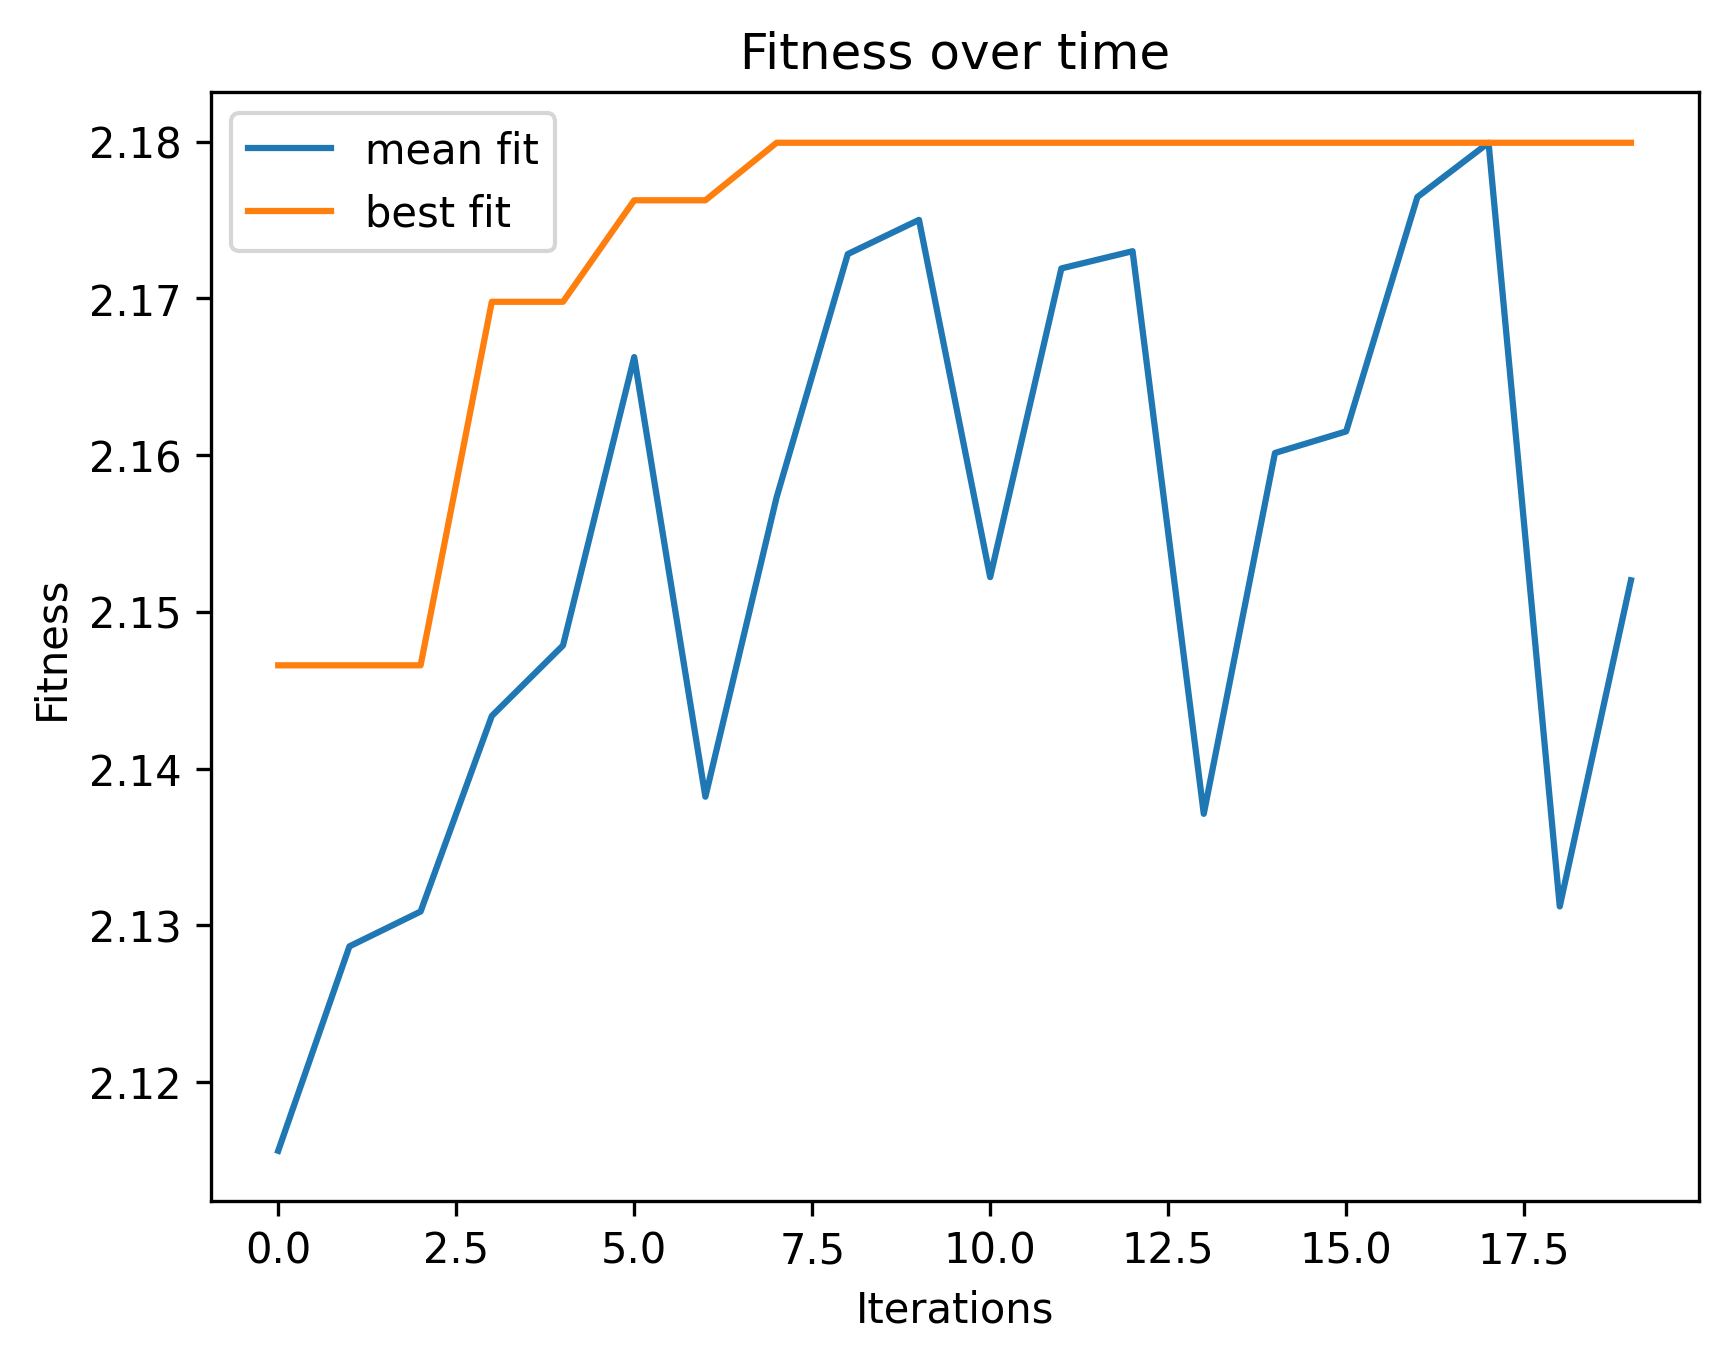

In [8]:
bf_vec, bf = algs.evolve1((6,3), [(0.5,0.85), (0.02,0.04), (0,0.5)], maxIter=20, fit_eval=fit_lbm, m_steps=[0.02, 0.004, 0.01], p_cross=0.9, p_mutate=0.34, elitism=0.15)

np.savetxt("bf_vec2.csv", bf_vec, delimiter=",")
np.savetxt("bf2.csv", bf, delimiter=",")

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.98it/s]


time to execute =  263.23553133010864


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.85it/s]


time to execute =  259.28023386001587


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.89it/s]


time to execute =  259.1260962486267


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.14it/s]


time to execute =  257.98093342781067


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.05it/s]


time to execute =  258.41099214553833


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.98it/s]


time to execute =  258.7211720943451


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.11it/s]


time to execute =  258.1090853214264


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.52it/s]


time to execute =  256.30999970436096


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:15<00:00, 58.73it/s]


time to execute =  255.419992685318


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.11it/s]


time to execute =  258.11999678611755


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:15<00:00, 58.66it/s]


time to execute =  255.71999835968018


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.86it/s]


time to execute =  259.22999691963196


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.06it/s]


time to execute =  262.8899986743927


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.43it/s]


time to execute =  261.1799988746643


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.92it/s]


time to execute =  259.00000381469727


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.32it/s]


time to execute =  257.2199981212616


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:15<00:00, 58.63it/s]


time to execute =  255.82999992370605


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.17it/s]


time to execute =  257.86999678611755


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:15<00:00, 58.60it/s]


time to execute =  255.97999215126038


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.13it/s]


time to execute =  258.05068612098694


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.58it/s]


time to execute =  256.06999945640564


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.29it/s]


time to execute =  257.3199999332428


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.29it/s]


time to execute =  257.3500008583069


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.53it/s]


time to execute =  256.2899947166443


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.05it/s]


time to execute =  258.3899977207184


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.49it/s]


time to execute =  256.46999859809875


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.22it/s]


time to execute =  257.6599986553192


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:15<00:00, 58.62it/s]


time to execute =  255.87999725341797


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.46it/s]


time to execute =  256.5699987411499


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.02it/s]


time to execute =  258.53999948501587


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.20it/s]


time to execute =  257.71999883651733


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.16it/s]


time to execute =  257.9199993610382


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.18it/s]


time to execute =  257.8199999332428


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:15<00:00, 58.69it/s]


time to execute =  255.61111569404602


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.25it/s]


time to execute =  261.99999952316284


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.48it/s]


time to execute =  260.95000290870667


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.35it/s]


time to execute =  261.5300009250641


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.32it/s]


time to execute =  257.21999883651733


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.27it/s]


time to execute =  257.46000027656555


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.31it/s]


time to execute =  257.239999294281


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.06it/s]


time to execute =  258.3599977493286


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.13it/s]


time to execute =  258.0499999523163


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.98it/s]


time to execute =  258.68999767303467


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.14it/s]


time to execute =  262.52999925613403


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.63it/s]


time to execute =  260.259996175766


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.37it/s]


time to execute =  261.48000144958496


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.59it/s]


time to execute =  256.0299997329712


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.27it/s]


time to execute =  257.43059515953064


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.16it/s]


time to execute =  257.90999817848206


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.22it/s]


time to execute =  257.64999890327454


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.16it/s]


time to execute =  257.9099998474121


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.93it/s]


time to execute =  258.9399983882904


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.04it/s]


time to execute =  262.9899990558624


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.43it/s]


time to execute =  261.1899993419647


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.54it/s]


time to execute =  260.67000007629395


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.03it/s]


time to execute =  258.5060615539551


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.99it/s]


time to execute =  258.6700005531311


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.01it/s]


time to execute =  258.5799946784973


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.28it/s]


time to execute =  257.3799982070923


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.99it/s]


time to execute =  258.6599977016449


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.02it/s]


time to execute =  258.5099983215332


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.47it/s]


time to execute =  261.0306749343872


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 57.02it/s]


time to execute =  263.0799994468689


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.71it/s]


time to execute =  259.94000029563904


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.01it/s]


time to execute =  258.57000064849854


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.78it/s]


time to execute =  259.60000014305115


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.97it/s]


time to execute =  258.77000069618225


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.02it/s]


time to execute =  258.5499997138977


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.00it/s]


time to execute =  258.6099967956543


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.60it/s]


time to execute =  260.42999958992004


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.11it/s]


time to execute =  262.66000175476074


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:32<00:00, 54.95it/s]


time to execute =  272.99599719047546


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.29it/s]


time to execute =  261.8099992275238


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.95it/s]


time to execute =  258.84000039100647


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.85it/s]


time to execute =  259.30229568481445


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.23it/s]


time to execute =  257.61999917030334


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.71it/s]


time to execute =  259.9099991321564


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.85it/s]


time to execute =  259.30999779701233


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.86it/s]


time to execute =  263.82000041007996


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 57.01it/s]


time to execute =  263.10000014305115


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.29it/s]


time to execute =  261.8399999141693


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 57.99it/s]


time to execute =  258.6799988746643


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.17it/s]


time to execute =  257.87999868392944


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.79it/s]


time to execute =  259.56999921798706


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.54it/s]


time to execute =  260.6899983882904


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.73it/s]


time to execute =  259.81000113487244


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.76it/s]


time to execute =  259.70000100135803


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.52it/s]


time to execute =  265.4099991321564


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.75it/s]


time to execute =  264.32096099853516


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.01it/s]


time to execute =  258.58000016212463


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.61it/s]


time to execute =  260.37999868392944


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.94it/s]


time to execute =  263.42999839782715


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.49it/s]


time to execute =  265.54999923706055


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.33it/s]


time to execute =  261.6600012779236


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.06it/s]


time to execute =  258.33999967575073


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.57it/s]


time to execute =  260.52999997138977


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:18<00:00, 58.05it/s]


time to execute =  258.39000058174133


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.52it/s]


time to execute =  260.77999901771545


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.78it/s]


time to execute =  259.5899999141693


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.54it/s]


time to execute =  265.2900011539459


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.14it/s]


time to execute =  267.1899981498718


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.97it/s]


time to execute =  263.2900013923645


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.47it/s]


time to execute =  261.01096200942993


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:19<00:00, 57.75it/s]


time to execute =  259.72000002861023


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.36it/s]


time to execute =  261.5099980831146


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.39it/s]


time to execute =  261.3499982357025


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.64it/s]


time to execute =  260.23999977111816


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.43it/s]


time to execute =  261.2099988460541


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.43it/s]


time to execute =  265.82999873161316


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.89it/s]


time to execute =  263.6700005531311


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.84it/s]


time to execute =  263.8947856426239


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.99it/s]


time to execute =  263.21000027656555


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.22it/s]


time to execute =  262.12999987602234


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.14it/s]


time to execute =  262.5299985408783


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.54it/s]


time to execute =  260.69999861717224


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.10it/s]


time to execute =  262.7199983596802


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.67it/s]


time to execute =  260.11101937294006


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.79it/s]


time to execute =  264.1600000858307


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.42it/s]


time to execute =  261.21999883651733


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.67it/s]


time to execute =  264.71000051498413


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.05it/s]


time to execute =  267.59999656677246


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.61it/s]


time to execute =  264.98609614372253


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.38it/s]


time to execute =  261.4099986553192


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.38it/s]


time to execute =  266.069997549057


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.15it/s]


time to execute =  267.1399986743927


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.58it/s]


time to execute =  265.129998922348


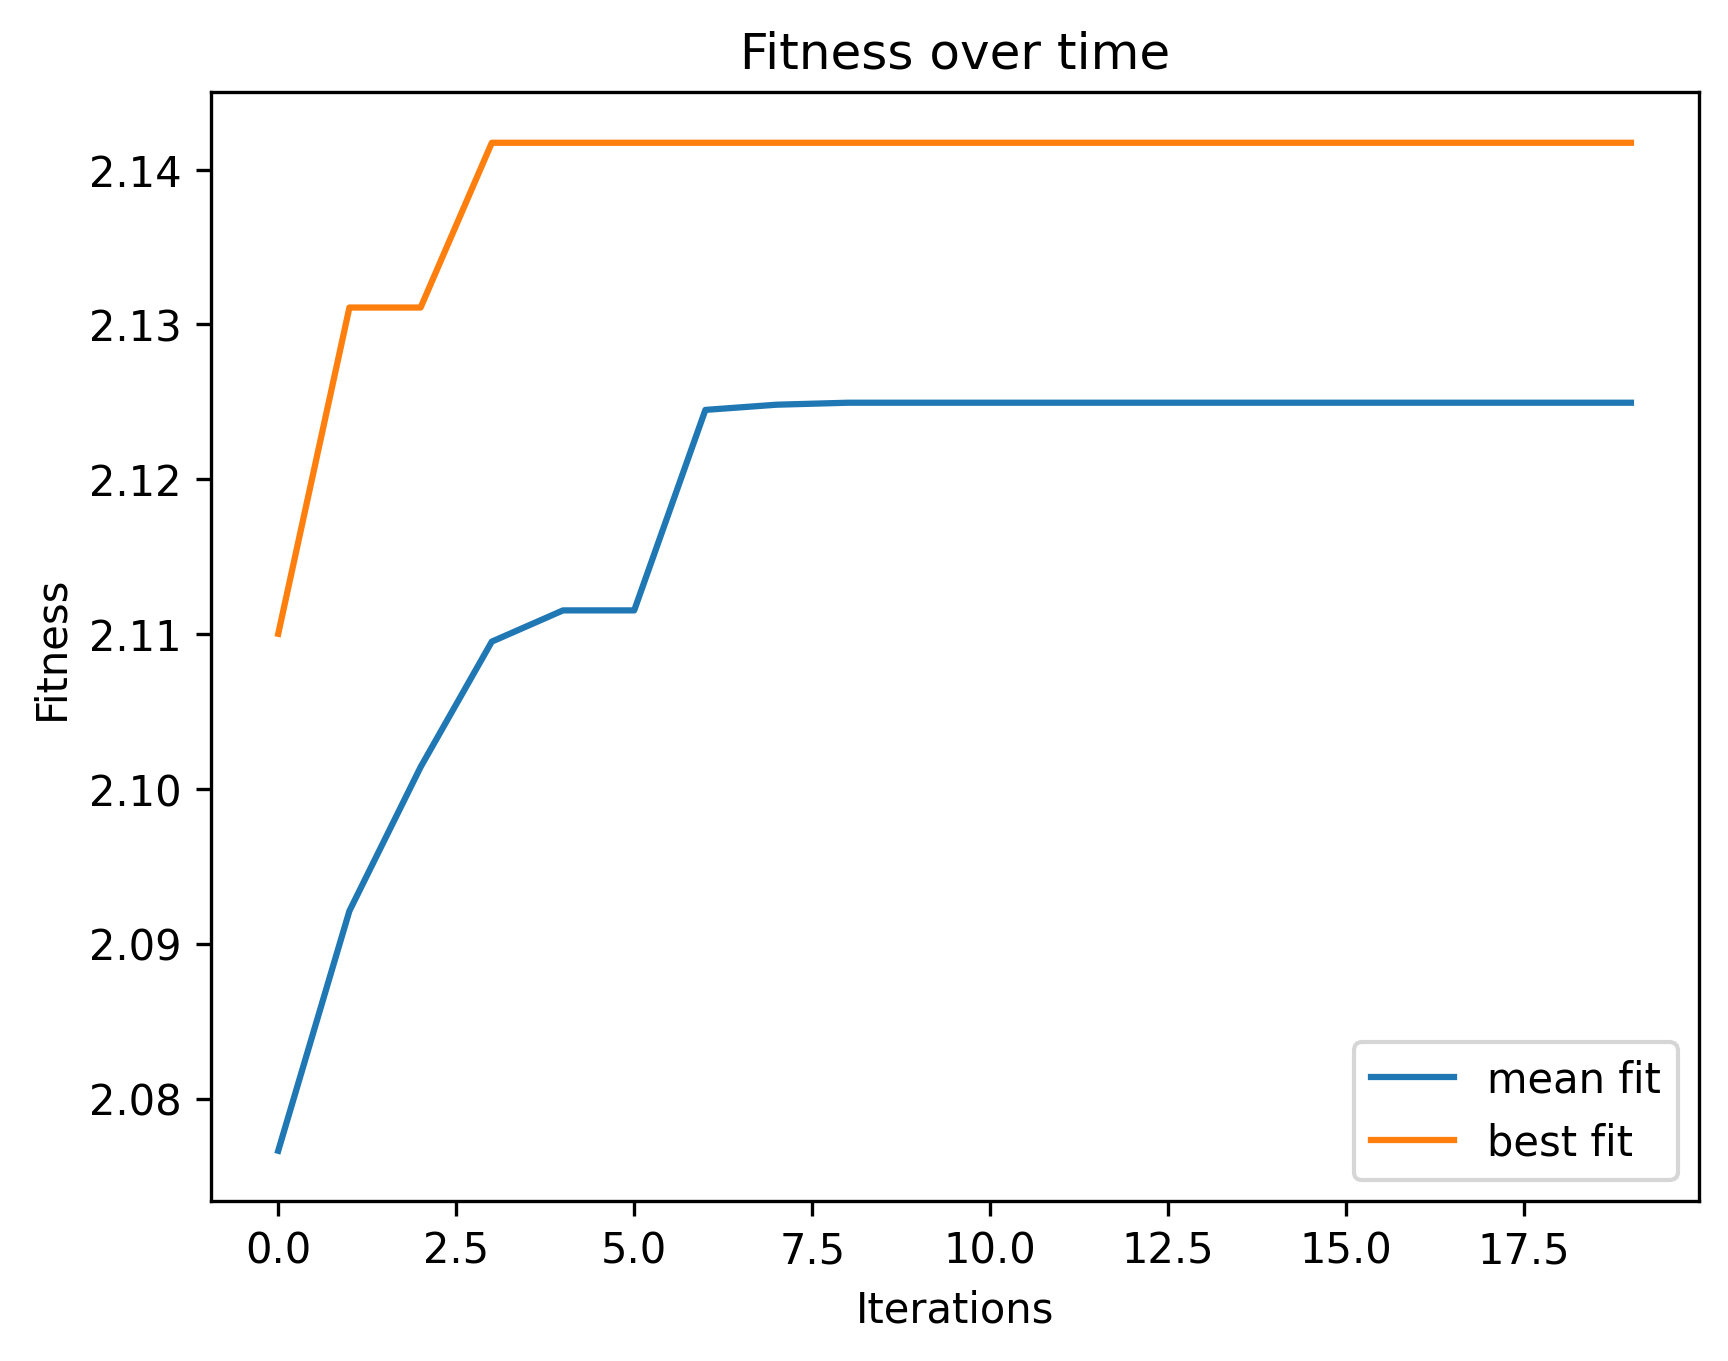

In [9]:
bf_vec_de, bf_de = algs.diff_evolve((6,3), [(0.5,0.85), (0.02,0.04), (0,0.5)], 20, F=1.5, c_rate=0.3, fit_eval=fit_lbm)

np.savetxt("bf_vec_de.csv", bf_vec_de, delimiter=",")
np.savetxt("bf_de.csv", bf_de, delimiter=",")

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.35it/s]


time to execute =  266.199990272522


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.62it/s]


time to execute =  264.94051575660706


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.94it/s]


time to execute =  263.45087695121765


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.55it/s]


time to execute =  260.6422770023346


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.24it/s]


time to execute =  262.08060097694397


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.58it/s]


time to execute =  260.5199975967407


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.18it/s]


time to execute =  267.00000047683716


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.85it/s]


time to execute =  263.8299980163574


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.27it/s]


time to execute =  261.93000054359436


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.54it/s]


time to execute =  260.7099974155426


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.23it/s]


time to execute =  257.59243726730347


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:17<00:00, 58.25it/s]


time to execute =  257.5199975967407


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.32it/s]


time to execute =  261.7099962234497


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.83it/s]


time to execute =  263.96000027656555


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.79it/s]


time to execute =  264.11834049224854


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.21it/s]


time to execute =  262.1699984073639


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.34it/s]


time to execute =  261.6200008392334


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.45it/s]


time to execute =  261.0910806655884


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.16it/s]


time to execute =  262.4300012588501


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.15it/s]


time to execute =  267.11999583244324


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.02it/s]


time to execute =  267.7699980735779


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.07it/s]


time to execute =  262.8499915599823


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.92it/s]


time to execute =  263.50952553749084


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.40it/s]


time to execute =  261.34999895095825


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.15it/s]


time to execute =  262.44999599456787


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.07it/s]


time to execute =  267.5399971008301


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.09it/s]


time to execute =  267.449999332428


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.44it/s]


time to execute =  261.1199998855591


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.27it/s]


time to execute =  266.589998960495


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.14it/s]


time to execute =  267.1996810436249


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.73it/s]


time to execute =  264.42999839782715


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.29it/s]


time to execute =  261.811021566391


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.04it/s]


time to execute =  262.979998588562


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.82it/s]


time to execute =  263.99999952316284


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.91it/s]


time to execute =  263.56999945640564


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.40it/s]


time to execute =  261.33999705314636


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:21<00:00, 57.44it/s]


time to execute =  261.1600000858307


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.09it/s]


time to execute =  267.43999457359314


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:28<00:00, 55.85it/s]


time to execute =  268.5800030231476


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.14it/s]


time to execute =  267.17997670173645


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.72it/s]


time to execute =  264.4500024318695


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.76it/s]


time to execute =  264.24999809265137


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.06it/s]


time to execute =  262.87999844551086


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 57.02it/s]


time to execute =  263.0799996852875


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.53it/s]


time to execute =  265.3399999141693


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.54it/s]


time to execute =  265.3007085323334


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:29<00:00, 55.56it/s]


time to execute =  269.9700040817261


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:29<00:00, 55.56it/s]


time to execute =  269.99999594688416


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.46it/s]


time to execute =  265.66999530792236


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.53it/s]


time to execute =  265.34063839912415


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.46it/s]


time to execute =  265.66999793052673


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.38it/s]


time to execute =  266.06751799583435


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.54it/s]


time to execute =  265.27999663352966


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.42it/s]


time to execute =  265.85999941825867


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.63it/s]


time to execute =  264.90000200271606


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:28<00:00, 55.82it/s]


time to execute =  268.7299995422363


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:30<00:00, 55.50it/s]


time to execute =  270.25999760627747


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:30<00:00, 55.37it/s]


time to execute =  270.90999269485474


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.31it/s]


time to execute =  266.36215257644653


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.07it/s]


time to execute =  267.53000116348267


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.29it/s]


time to execute =  266.4999976158142


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.46it/s]


time to execute =  265.6699995994568


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.38it/s]


time to execute =  266.06000089645386


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.30it/s]


time to execute =  266.4500000476837


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:31<00:00, 55.25it/s]


time to execute =  271.46999859809875


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:31<00:00, 55.34it/s]


time to execute =  271.0322971343994


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:30<00:00, 55.43it/s]


time to execute =  270.58999848365784


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.90it/s]


time to execute =  263.6299982070923


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.30it/s]


time to execute =  266.44999980926514


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.43it/s]


time to execute =  265.8299996852875


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.07it/s]


time to execute =  267.5399980545044


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.60it/s]


time to execute =  265.0400002002716


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.28it/s]


time to execute =  266.51099848747253


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:30<00:00, 55.46it/s]


time to execute =  270.46999645233154


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:30<00:00, 55.54it/s]


time to execute =  270.0600016117096


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:28<00:00, 55.78it/s]


time to execute =  268.9100019931793


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.09it/s]


time to execute =  267.41999793052673


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.04it/s]


time to execute =  267.64999628067017


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.52it/s]


time to execute =  265.3899986743927


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.50it/s]


time to execute =  265.510000705719


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.24it/s]


time to execute =  266.72999930381775


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:27<00:00, 56.17it/s]


time to execute =  267.05999970436096


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:33<00:00, 54.84it/s]


time to execute =  273.5000014305115


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:33<00:00, 54.76it/s]


time to execute =  273.93999886512756


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:31<00:00, 55.21it/s]


time to execute =  271.7099959850311


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.04it/s]


time to execute =  262.96093368530273


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.50it/s]


time to execute =  265.4800000190735


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.84it/s]


time to execute =  263.9099955558777


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:28<00:00, 55.79it/s]


time to execute =  268.8799991607666


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.49it/s]


time to execute =  265.5300016403198


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:33<00:00, 54.81it/s]


time to execute =  273.65000009536743


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:30<00:00, 55.50it/s]


time to execute =  270.2899992465973


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:28<00:00, 55.82it/s]


time to execute =  268.74000000953674


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.59it/s]


time to execute =  260.47999906539917


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.27it/s]


time to execute =  266.5800015926361


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:28<00:00, 55.83it/s]


time to execute =  268.678662776947


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:28<00:00, 55.81it/s]


time to execute =  268.7699978351593


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.56it/s]


time to execute =  265.21999621391296


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.60it/s]


time to execute =  265.040940284729


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:29<00:00, 55.67it/s]


time to execute =  269.45000100135803


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:32<00:00, 55.12it/s]


time to execute =  272.14999985694885


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:31<00:00, 55.21it/s]


time to execute =  271.67999291419983


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:28<00:00, 55.97it/s]


time to execute =  268.02000069618225


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.93it/s]


time to execute =  263.4899983406067


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.78it/s]


time to execute =  264.18000054359436


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.68it/s]


time to execute =  260.03999972343445


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.23it/s]


time to execute =  266.73954367637634


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:31<00:00, 55.31it/s]


time to execute =  271.2110984325409


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.38it/s]


time to execute =  266.07031440734863


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.56it/s]


time to execute =  265.2099986076355


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.81it/s]


time to execute =  264.05000019073486


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 56.98it/s]


time to execute =  263.26751708984375


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:28<00:00, 55.87it/s]


time to execute =  268.4821922779083


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.18it/s]


time to execute =  266.99000239372253


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:26<00:00, 56.30it/s]


time to execute =  266.4406805038452


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.50it/s]


time to execute =  265.50999999046326


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.73it/s]


time to execute =  264.410001039505


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 57.01it/s]


time to execute =  263.1100013256073


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.75it/s]


time to execute =  264.330153465271


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:25<00:00, 56.46it/s]


time to execute =  265.6699917316437


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 57.00it/s]


time to execute =  263.14000058174133


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.69it/s]


time to execute =  264.58999609947205


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.65it/s]


time to execute =  260.1900007724762


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:23<00:00, 57.00it/s]


time to execute =  263.17999935150146


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:20<00:00, 57.58it/s]


time to execute =  260.509996175766


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:24<00:00, 56.66it/s]


time to execute =  264.71999979019165


NameError: name 'bf_vec_de' is not defined

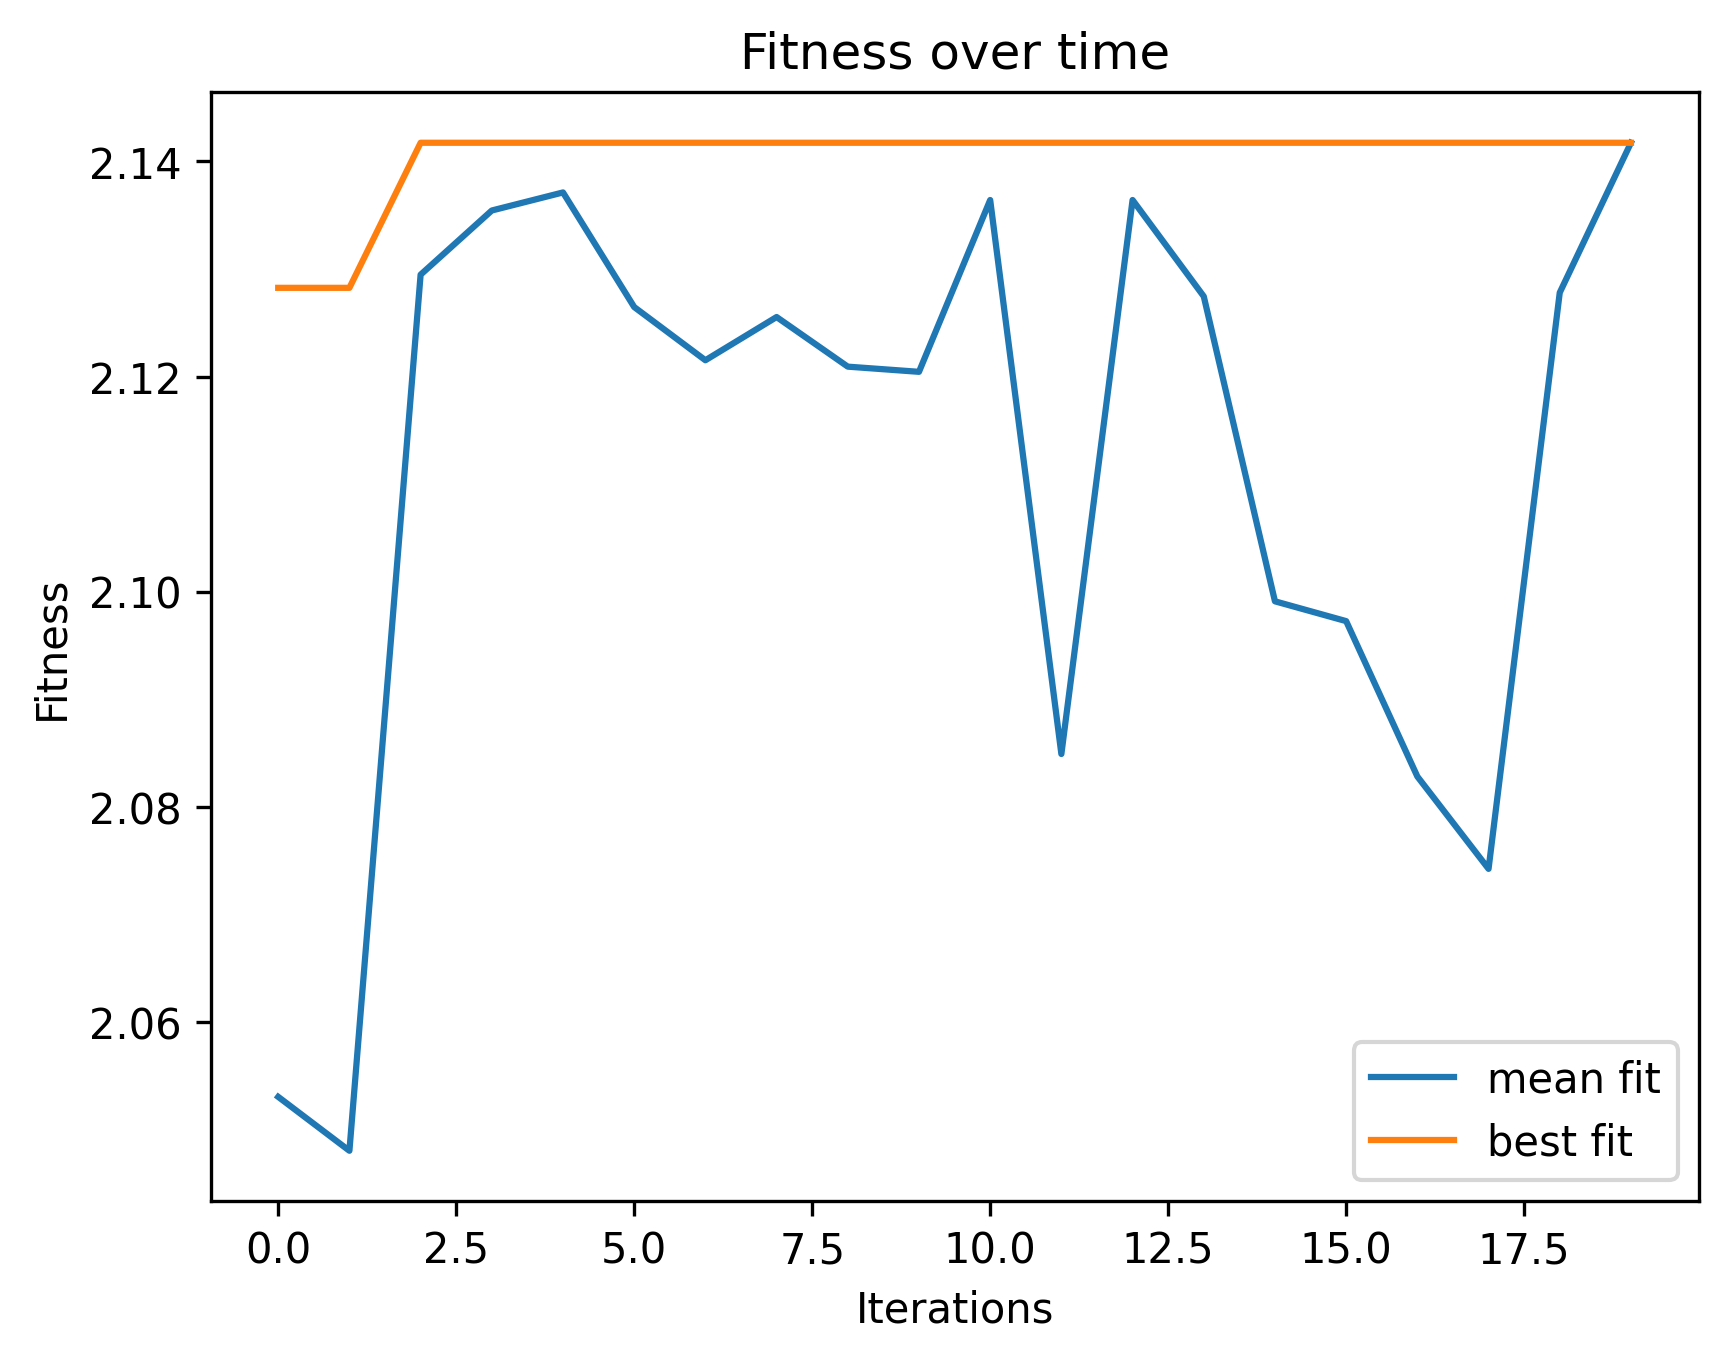

In [10]:
bf_vec_pso, bf_pso = algs.pso_alg((6,3),[(0.5,0.85), (0.02,0.04), (0,0.5)],20,w=0.5,phi1=1.8,phi2=2,fit_eval=fit_lbm)

np.savetxt("bf_vec_pso.csv", bf_vec_de, delimiter=",")
np.savetxt("bf_pso.csv", bf_de, delimiter=",")

---
---

In [30]:
profiles = pd.read_csv('best_profiles.csv')
np.asarray(profiles.iloc[0])

array([0.797 , 0.04  , 0.0369])

In [25]:
ang_deg = [2*i for i in range(15)]
Cd_ang = []
Cl_ang = []

for i in range(15):
    ang_atk = np.pi*(i/90)
    obstacle_mask = obs.get_profile_mask(np.asarray(profiles.iloc[1]), rot_ang=ang_atk)
    extbdry_mask = obs.get_extbdry_mask(obstacle_mask)
    obstacle = tensor(obstacle_mask).to(device)
    extbdry = obs.get_links(obstacle_mask, extbdry_mask)
    Cl, Cd = lbm.lbm_sim(extbdry, obstacle, nx, ny, 1000.0, uLB=0.2/np.sqrt(3), C=125, tF_start=10_000)
    # np.savetxt("Cl_es{0:03d}.csv".format(i), Cl, delimiter=",")
    # np.savetxt("Cd_es{0:03d}.csv".format(i), Cd, delimiter=",")
    Cl_ang.append(tsum(Cl.cpu())/50)
    Cd_ang.append(tsum(Cd.cpu())/50)

np.savetxt("Cl_de_avg.csv", np.asarray(Cl_ang), delimiter=",")
np.savetxt("Cd_de_avg.csv", np.asarray(Cd_ang), delimiter=",")

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:36<00:00, 21.53it/s]


time to execute =  696.7672829627991


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:32<00:00, 21.65it/s]


time to execute =  692.9118871688843


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:30<00:00, 21.72it/s]


time to execute =  690.7371201515198


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:33<00:00, 21.64it/s]


time to execute =  693.0397200584412


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:37<00:00, 21.51it/s]


time to execute =  697.4241454601288


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:38<00:00, 21.47it/s]


time to execute =  698.581690788269


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:31<00:00, 21.68it/s]


time to execute =  691.9258797168732


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:36<00:00, 21.53it/s]


time to execute =  696.7358422279358


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:39<00:00, 21.45it/s]


time to execute =  699.3347587585449


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:43<00:00, 21.31it/s]


time to execute =  703.9704871177673


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:39<00:00, 21.46it/s]


time to execute =  699.0924425125122


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:31<00:00, 21.69it/s]


time to execute =  691.5392186641693


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:39<00:00, 21.44it/s]


time to execute =  699.735547542572


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:37<00:00, 21.50it/s]


time to execute =  697.7458600997925


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [11:39<00:00, 21.44it/s]

time to execute =  699.5807650089264


In [24]:
np.savetxt("Cl_es_avg.csv", np.asarray(Cl_ang), delimiter=",")
np.savetxt("Cd_es_avg.csv", np.asarray(Cd_ang), delimiter=",")

---
---

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
ang_deg = [2*i for i in range(15)]

Cl_nb = np.asarray(pd.read_csv("Fdata/Cl.csv").iloc[:,0])
Cd_nb = np.asarray(pd.read_csv("Fdata/Cd.csv").iloc[:,0])

Cl_de = np.asarray(pd.read_csv("Fdata/Cl_de_avg.csv").iloc[:,0])
Cd_de = np.asarray(pd.read_csv("Fdata/Cd_de_avg.csv").iloc[:,0])

Cl_es = np.asarray(pd.read_csv("Fdata/Cl_es_avg.csv").iloc[:,0])
Cd_es = np.asarray(pd.read_csv("Fdata/Cd_es_avg.csv").iloc[:,0])

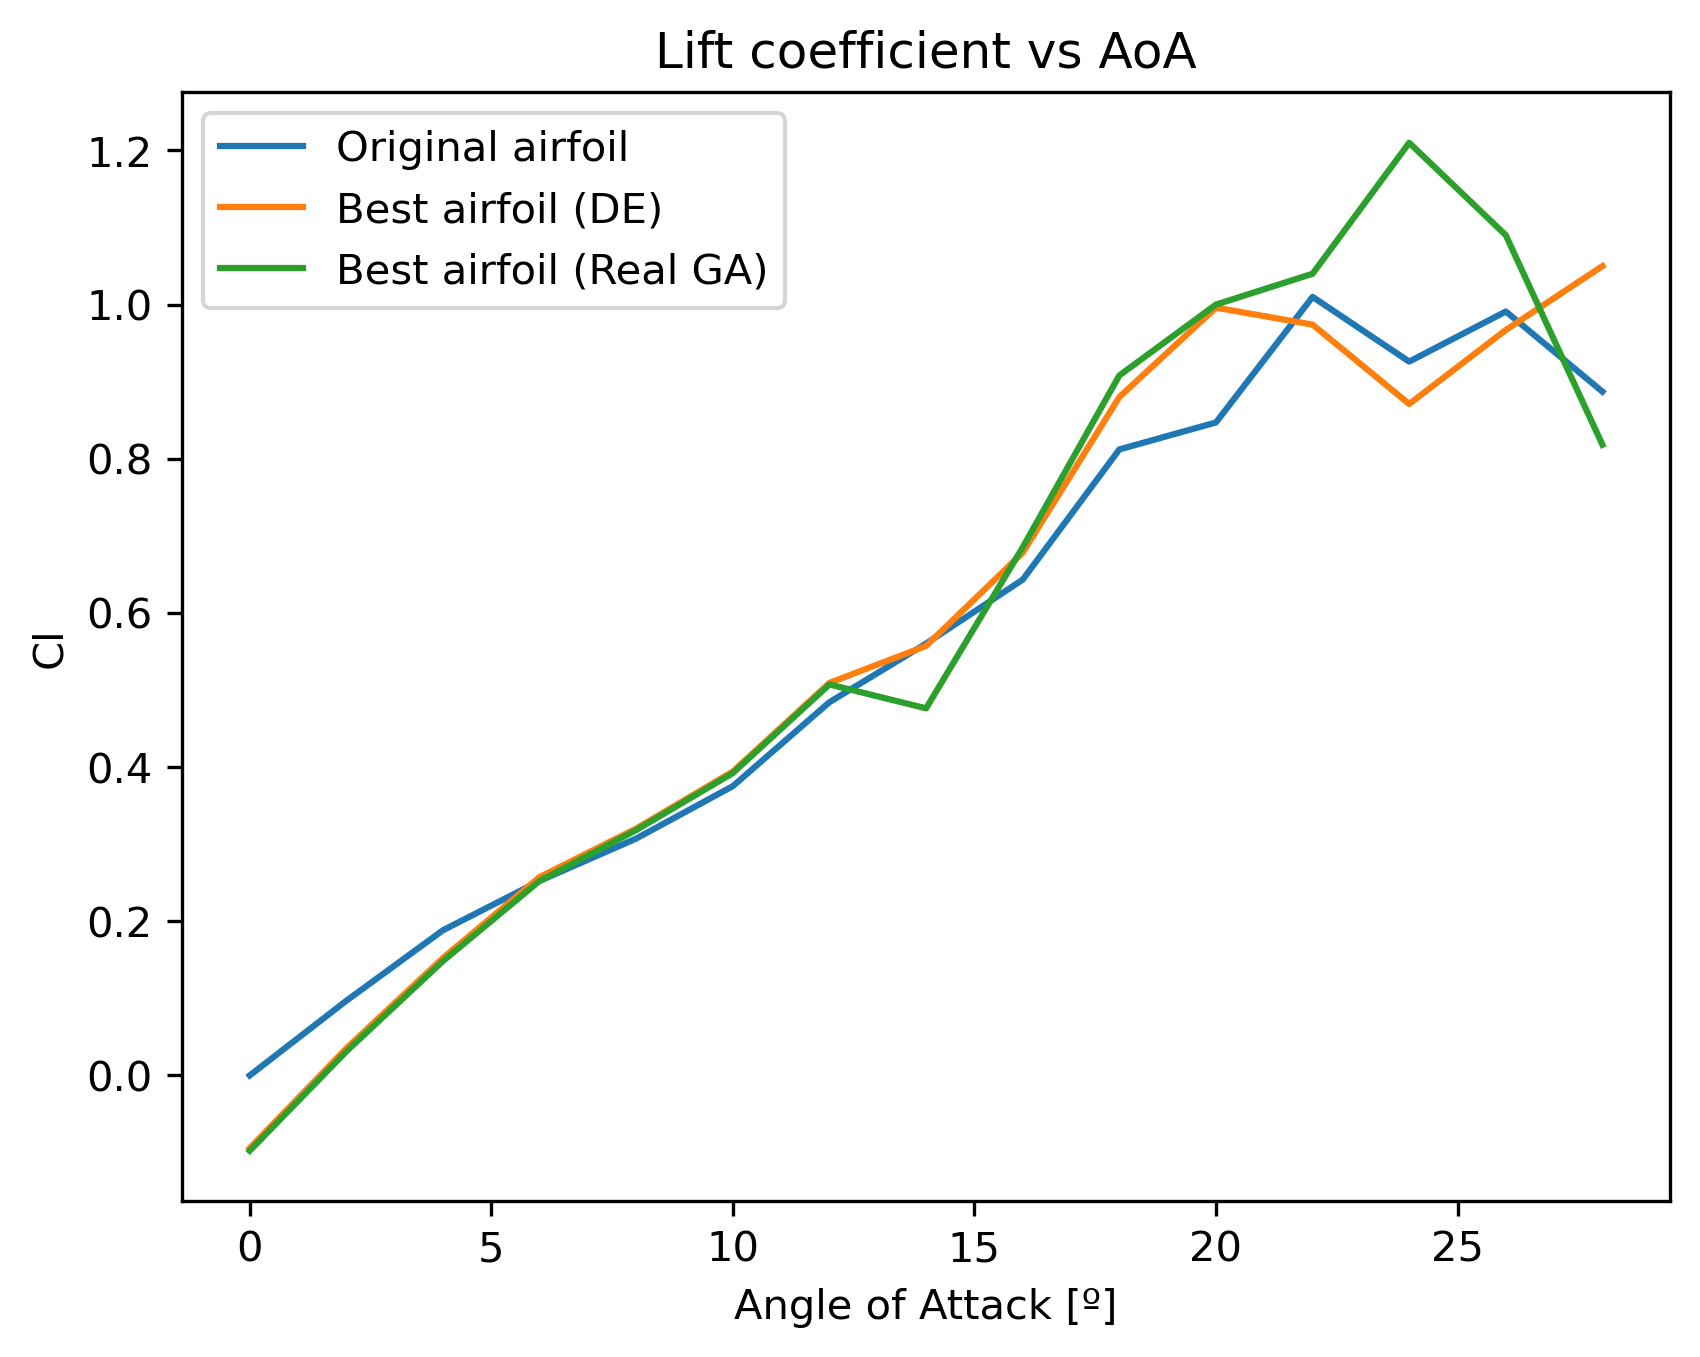

In [33]:
plt.plot(ang_deg, Cl_nb, label="Original airfoil")
plt.plot(ang_deg, Cl_de, label="Best airfoil (DE)")
plt.plot(ang_deg, Cl_es, label="Best airfoil (Real GA)")

plt.title("Lift coefficient vs AoA")
plt.xlabel("Angle of Attack [º]")
plt.ylabel("Cl")
plt.legend()
plt.gcf().set_dpi(300)
plt.savefig("liftVaoa.png", dpi=300)

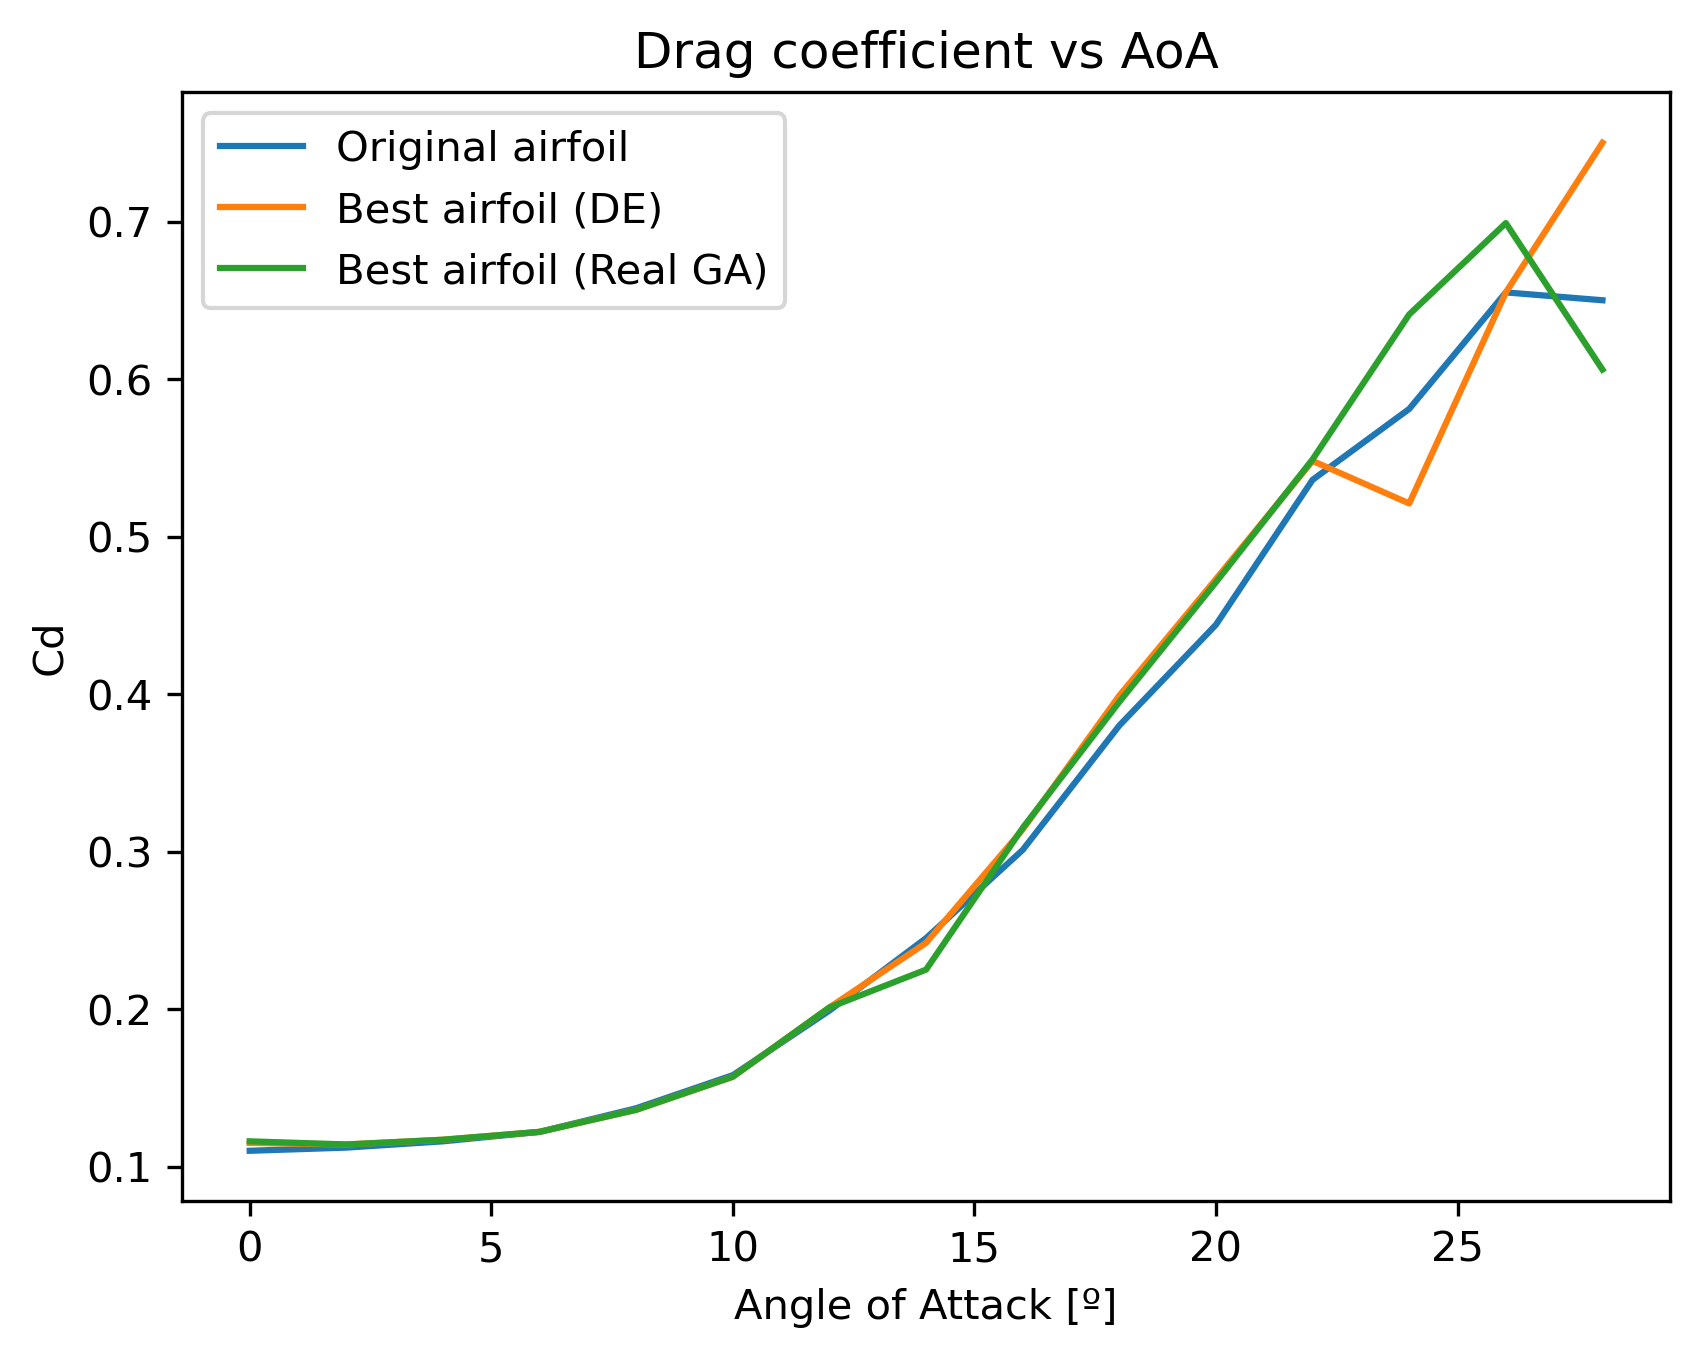

In [32]:
plt.plot(ang_deg, Cd_nb, label="Original airfoil")
plt.plot(ang_deg, Cd_de, label="Best airfoil (DE)")
plt.plot(ang_deg, Cd_es, label="Best airfoil (Real GA)")

plt.title("Drag coefficient vs AoA")
plt.xlabel("Angle of Attack [º]")
plt.ylabel("Cd")
plt.legend()
plt.gcf().set_dpi(300)
plt.savefig("dragVaoa.png", dpi=300)

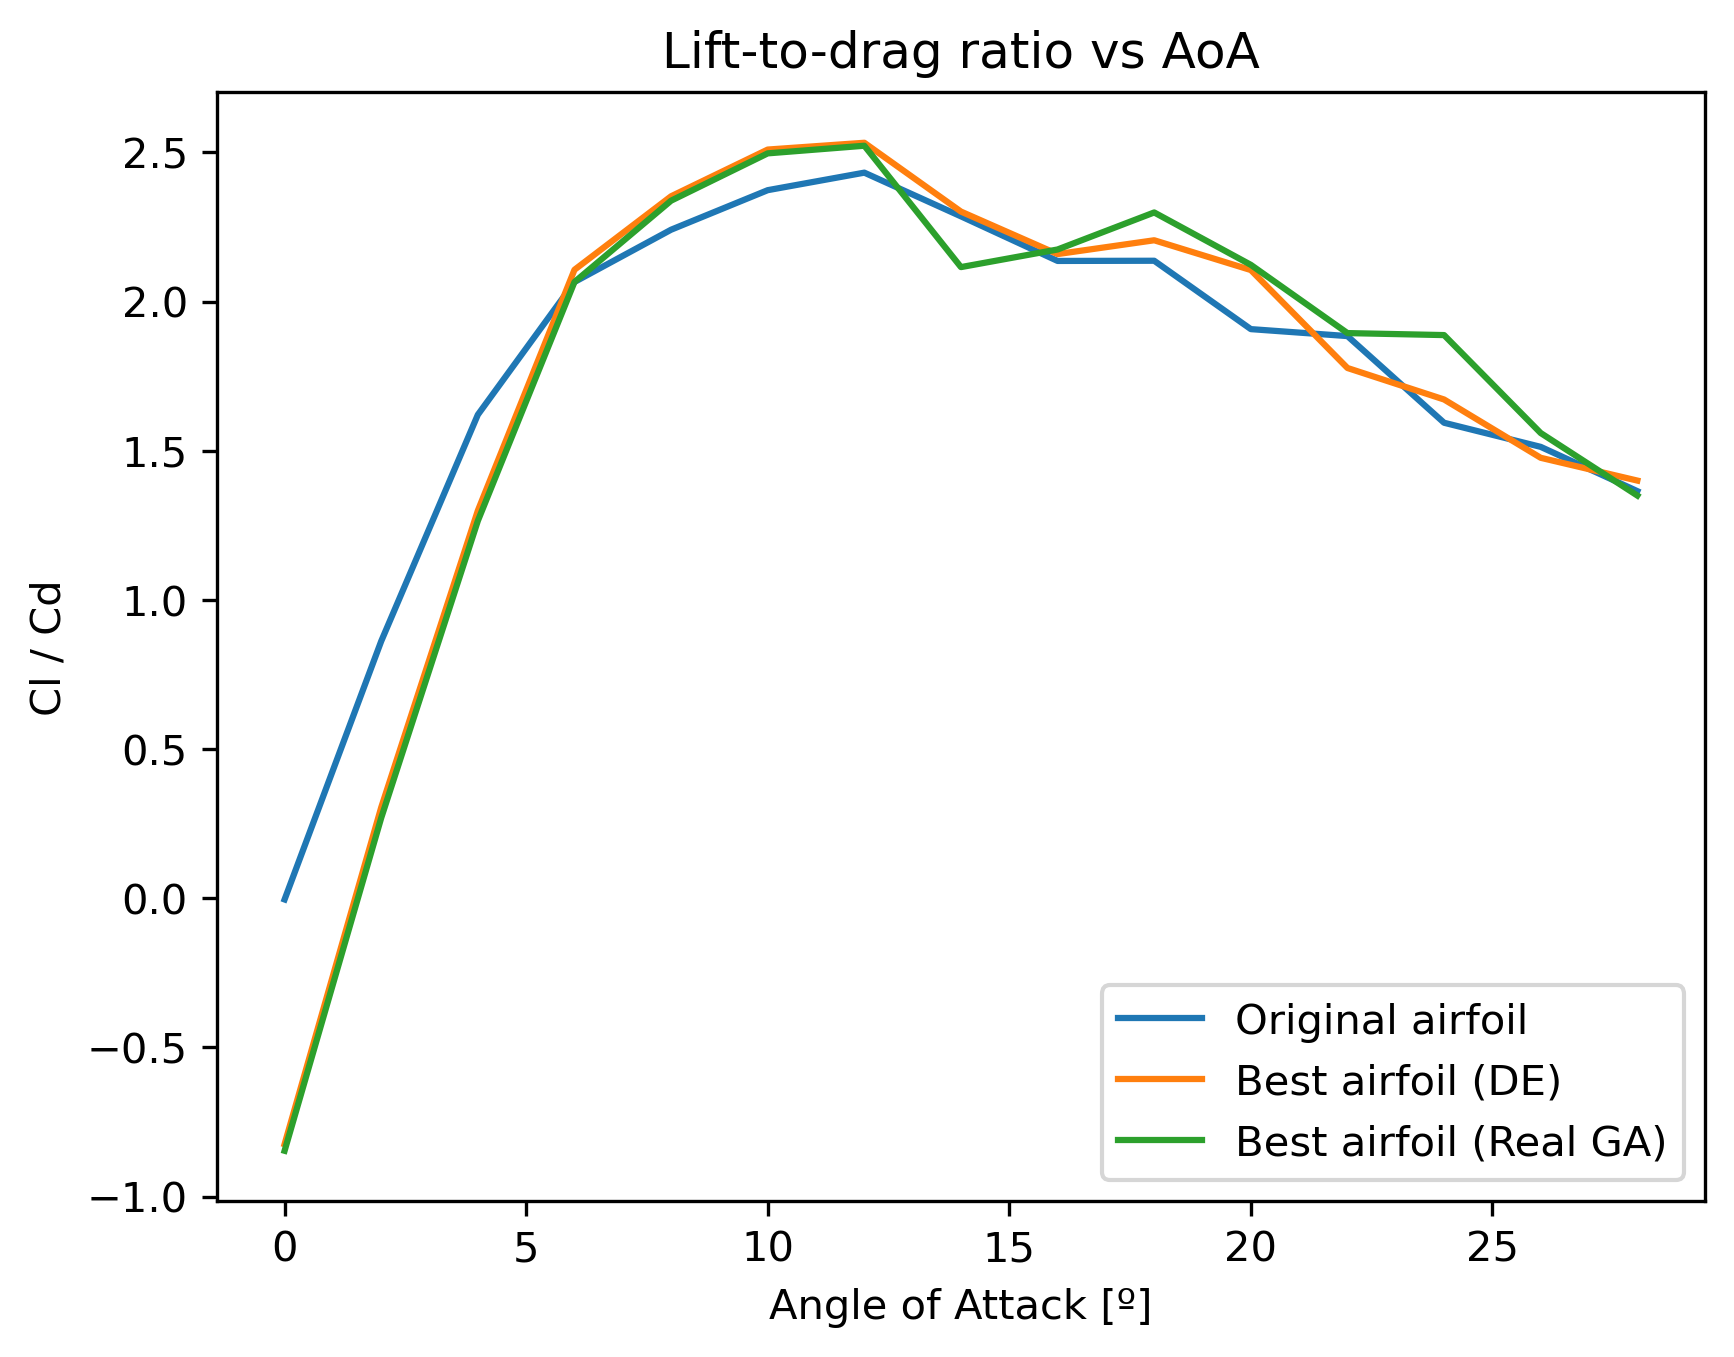

In [34]:
plt.plot(ang_deg, Cl_nb/Cd_nb, label="Original airfoil")
plt.plot(ang_deg, Cl_de/Cd_de, label="Best airfoil (DE)")
plt.plot(ang_deg, Cl_es/Cd_es, label="Best airfoil (Real GA)")

plt.title("Lift-to-drag ratio vs AoA")
plt.xlabel("Angle of Attack [º]")
plt.ylabel("Cl / Cd")
plt.legend()
plt.gcf().set_dpi(300)
plt.savefig("l-to-dVaoa.png", dpi=300)